In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import tensorflow as tf
import pandas as pd
import os
import pickle
import random
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from itertools import groupby 
from scipy import stats
plt.rcParams.update({'font.size': 16})

In [2]:
sub_ses = [['SD010','01'],
           ['SD011','01'],
           ['SD012','02'],
           ['SD013','01'],
           ['SD015','01'],
           ['SD017','01'],
           ['SD018','01'],
           ['SD019-split1','01'],
           ['SD019-split2','01'],
           ['SD021','01'],
           ['SD022','01']]
bands = ['d','th','a','b','g','hg']
bands2 = ['dp','thp','ap','bp','gp','hgp']
mods = ['s1p1','s1','p1','s2','p2','s3','p3']
eng_stims = ('s1303a','s1401a','s1901b','s2102a','s2301a','s3001b','s3602b','s4002b')

In [3]:
with open('Figure5-8a/lme_catalan_r_means.pkl','rb') as f:
    catalan_means = pickle.load(f)

with open('Figure5-8a/lme_english_r_means.pkl','rb') as f:
    english_means = pickle.load(f)
    
with open('Figure5-8a/figure5ab_dic.pkl','rb') as f:
    nocomp_dic = pickle.load(f)

### Figure 5 a&b

In [4]:
mods = ['s1p1','s1','p1','s2','s3','p2','p3']
colors2 = ['indianred','palegoldenrod','dodgerblue']
anchors = [0.0,0.5, 1.0]
cmap3 = LinearSegmentedColormap.from_list("mycmap2", list(zip(anchors, colors2)))
colors = [cmap3(0.0), cmap3(0.2), cmap3(0.4),cmap3(0.6), cmap3(0.8), cmap3(1.0),'grey']

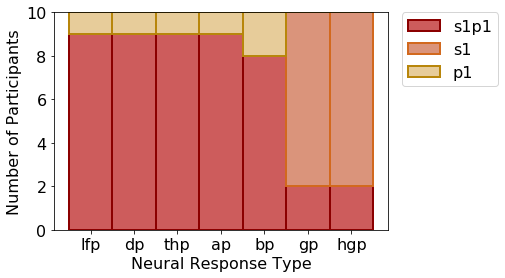

In [5]:
labels =['lfp','dp','thp','ap','bp','gp','hgp']
width = 1       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
ax.bar(labels, nocomp_dic['first']['s1p1'], width, color=colors[0],label='s1p1',edgecolor='darkred',linewidth=2)
ax.bar(labels, nocomp_dic['first']['s1'], width, bottom=nocomp_dic['first']['s1p1'], color=colors[1],edgecolor='chocolate',linewidth=2,
       label='s1')
ax.bar(labels, [x-1 for x in nocomp_dic['first']['p1']], width, bottom=[x+y for x,y in zip(nocomp_dic['first']['s1p1'], nocomp_dic['first']['s1'])], color=colors[2],edgecolor='darkgoldenrod',linewidth=2,label='p1')

ax.set_ylabel('Number of Participants')
ax.set_xlabel('Neural Response Type')
ax.set_yticks([0, 2, 4, 6, 8, 10])
#ax.set_title('Best-fit Model by Frequency Band')
ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.show()

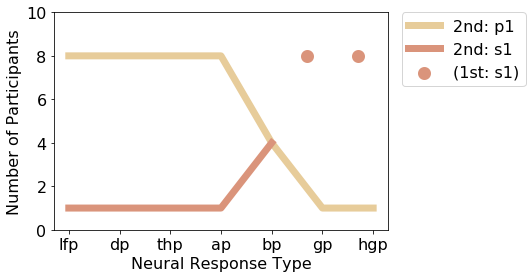

In [6]:
fig, ax = plt.subplots()
ax.plot(nocomp_dic['second']['p1'], label='2nd: p1', c=colors[2], lw=7)
ax.plot(nocomp_dic['second']['s1'][:-2], label='2nd: s1', c=colors[1], lw=7)
ax.scatter([4.7,5.7],[nocomp_dic['first']['s1'][-2],nocomp_dic['first']['s1'][-1]], label='(1st: s1)', c=[colors[1]], lw=7)
ax.set_xticklabels(['lfp','dp','thp','ap','bp','gp','hgp'])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('Number of Participants')
ax.set_xlabel('Neural Response Type')
#ax.set_title('Second Best-Fit Model by Frequency Band')
ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.show()

### Figure 5 c&d

In [7]:
ch_dic = {}
for band in bands:
    sp_fname = 'speech_selective_chs_band-%s.pkl'%(band)
    with open(sp_fname,'rb') as f:
        ch_dic[band] = pickle.load(f)

In [8]:
def window_std(array, win_len):
    new_array = np.zeros(len(array))
    for i in range(len(array)):
        new_array[i] = np.std(array[i:i+win_len])
    return new_array

In [9]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [10]:
def all_mods_dic(sub, neu, ex):
    sname = "Figure5-8a/sub-{}_band-{}_ex-{}_no-comp_pred_corrs.pkl".format(sub,neu,ex)
    pname = "Figure5-8a/sub-{}_band-{}_ex-{}_gaia_pred_corrs.pkl".format(sub,neu,ex)
    with open(sname, 'rb') as f:
        e_corrdic_s = pickle.load(f)
    with open(pname, 'rb') as f:
        e_corrdic = pickle.load(f)
    
    mods = ['s1p1','s1','p1','s2','p2','s3','p3']
    for mod in mods:
        if mod in ['p1','p2','p3']:
            line = e_corrdic['mods'][mod]
            nans, preline = nan_helper(line)
            line[nans]= np.interp(preline(nans), preline(~nans), line[~nans])
            e_corrdic['mods'][mod] = line
        else:
            line = e_corrdic_s['mods'][mod]
            nans, preline = nan_helper(line)
            line[nans]= np.interp(preline(nans), preline(~nans), line[~nans])
            e_corrdic['mods'][mod] = line
                
    return e_corrdic

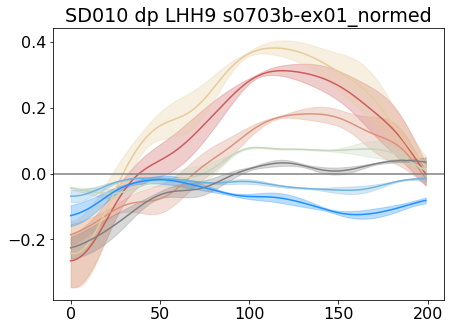

In [11]:
#Figure 4
sub, ses, neu = 'SD010', '01', 'dp'
ex = 's0703b-ex01_normed'
fname = 'Figure5-8a/sub-{}_band-{}_ex-{}_gaia_pred_corrs.pkl'.format(sub,neu,ex)
with open(fname, 'rb') as f:
    e_corrdic = pickle.load(f)

colors2 = ['indianred','palegoldenrod','dodgerblue']
anchors = [0.0,0.5, 1.0]
cmap3 = LinearSegmentedColormap.from_list("mycmap2", list(zip(anchors, colors2)))
colors = [cmap3(0.0), cmap3(0.2), cmap3(0.4),cmap3(0.6), cmap3(0.8), cmap3(1.0),'grey']

mods = ['s1p1','s1','p1','s2','p2','s3','p3']
ch = "LHH9"

fig,ax = plt.subplots(1,1,figsize=(7,5))
ch_idx = [x for x in range(len(e_corrdic['ch'])) if e_corrdic['ch'][x]==ch]
for k,col in zip(mods, colors):
    preline = e_corrdic['mods'][k][ch_idx]
    if len(preline)>800:
        line = gaussian_filter(preline, sigma=12)[:-100]
        se = window_std(line, 35)[:-20]
        if 'catalan' in ex:
            line = gaussian_filter(preline, sigma=12)[:-20]
            se = window_std(line, 12)[:-20]
        ax.plot(line[600:800], c=col)
        ax.fill_between(range(200), line[600:800]-se[600:800], line[600:800]+se[600:800], color=col, alpha=0.3)
ax.axhline(0, c='grey')
ax.set_title("%s %s %s %s"%(sub, neu, ch, ex))
plt.show()

#### Figure 5c

In [12]:
sub,ses = "SD010", "01"
ch = "LA6"
neu = 'dp'
ex = 's3703b-ex01_normed'
fpath = 'Figure5-8a/sub-SD010_ch-LA6_band-d_s3703b-ex01_normed_MNE_phone-masks.pkl'
with open(fpath, 'rb') as f:
    mne_stim_data = pickle.load(f)
mne_stim_data.keys()

phone_labels = []
phones = list(mne_stim_data['phone_masks'].keys())
masks = mne_stim_data['phone_masks']
for i in range(len(masks[phones[0]])):
    vec = [masks[p][i] for p in phones]
    phone_labels.append(phones[np.argmax(vec)])

res = [(i[0],len([x for x in i[1]])) for i in groupby(phone_labels[480:680])]

for x in range(len(res)-1):
    res[x+1] = (res[x+1][0], res[x][1]+res[x+1][1])
print(res)

[('VOCNOISE', 2), ('ae', 8), ('n', 10), ('d', 11), ('jh', 12), ('ih', 16), ('s', 17), ('l', 19), ('ih', 21), ('k', 23), ('t', 25), ('ah', 29), ('p', 31), ('er', 34), ('s', 37), ('b', 39), ('ay', 41), ('jh', 42), ('ih', 43), ('z', 45), ('b', 47), ('ah', 50), ('p', 52), ('er', 54), ('s', 55), ('n', 58), ('el', 60), ('k', 62), ('aa', 64), ('r', 65), ('y', 67), ('uw', 69), ('k', 72), ('en', 73), ('g', 82), ('ow', 88), ('VOCNOISE', 90), ('y', 93), ('ah', 98), ('ow', 101), ('SIL', 102), ('ah', 105), ('k', 107), ('r', 109), ('ao', 111), ('s', 119), ('VOCNOISE', 121), ('ch', 122), ('ih', 123), ('s', 126), ('g', 130), ('ow', 132), ('ih', 134), ('k', 135), ('r', 137), ('ao', 140), ('d', 141), ('ah', 144), ('b', 147), ('ow', 148), ('r', 149), ('dx_d', 150), ('ih', 151), ('y', 155), ('ih', 157), ('k', 158), ('ih', 159), ('n', 161), ('d', 164), ('ey', 166), ('n', 168), ('g', 175), ('ow', 182), ('en', 183), ('v', 185), ('ih', 187), ('z', 190), ('ih', 195), ('t', 200)]


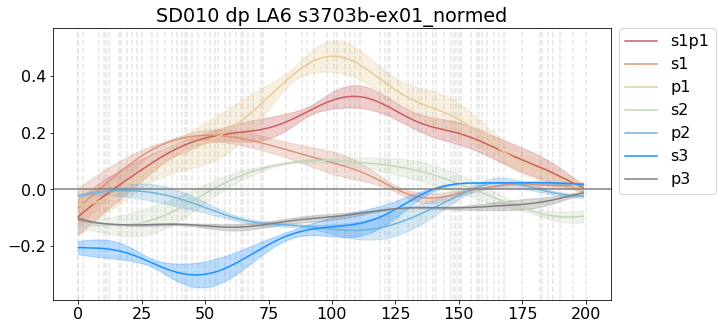

['VOCNOISE', 'ae', 'n', 'd', 'jh', 'ih', 's', 'l', 'ih', 'k', 't', 'ah', 'p', 'er', 's', 'b', 'ay', 'jh', 'ih', 'z', 'b', 'ah', 'p', 'er', 's', 'n', 'el', 'k', 'aa', 'r', 'y', 'uw', 'k', 'en', 'g', 'ow', 'VOCNOISE', 'y', 'ah', 'ow', 'SIL', 'ah', 'k', 'r', 'ao', 's', 'VOCNOISE', 'ch', 'ih', 's', 'g', 'ow', 'ih', 'k', 'r', 'ao', 'd', 'ah', 'b', 'ow', 'r', 'dx_d', 'ih', 'y', 'ih', 'k', 'ih', 'n', 'd', 'ey', 'n', 'g', 'ow', 'en', 'v', 'ih', 'z', 'ih', 't']


In [13]:
## The location of the correlation dictionary
sub, ses, neu = 'SD010', '01', 'dp'
ex = 's3703b-ex01_normed'
e_corrdic = all_mods_dic(sub, neu, ex)

colors2 = ['indianred','palegoldenrod','dodgerblue']
anchors = [0.0,0.5, 1.0]
cmap3 = LinearSegmentedColormap.from_list("mycmap2", list(zip(anchors, colors2)))
colors = [cmap3(0.0), cmap3(0.2), cmap3(0.4),cmap3(0.6), cmap3(0.8), cmap3(1.0),'grey']

mods = ['s1p1','s1','p1','s2','p2','s3','p3']
ch = "LA6"

#for which indices to plot
idx1, idx2 = 480,680


fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.axvline(0, c='grey', ls='dashed', alpha=0.3)
for x in res:
    ax.axvline(x[1], c='grey', ls='dashed', alpha=0.2)
ch_idx = [x for x in range(len(e_corrdic['ch'])) if e_corrdic['ch'][x]==ch]
for k,col in zip(mods, colors):
    preline = e_corrdic['mods'][k][ch_idx]
    if len(preline)>800:
        line = gaussian_filter(preline, sigma=12)[:-100]
        se = window_std(line, 35)[:-20]
        if 'catalan' in ex:
            line = gaussian_filter(preline, sigma=12)[:-20]
            se = window_std(line, 12)[idx1:idx2]
        ax.plot(line[idx1:idx2], c=col, label=k)
        ax.fill_between(range(len(line[idx1:idx2])), line[idx1:idx2]-se[idx1:idx2], line[idx1:idx2]+se[idx1:idx2], color=col, alpha=0.3)
ax.axhline(0, c='grey')
ax.set_title("%s %s %s %s"%(sub, neu, ch, ex))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
plt.show()
print([x[0] for x in res])

and just like the pers-- by just by personal car you can go y'know across just go across the border and you can then go and visit

#### Figure 5d

In [14]:
sub,ses = "SD010", "01"
ch = "LOF10"
neu = 'hgp'
ex = 's3201a-ex01_normed'
fpath = 'Figure5-8a/sub-SD010_ch-LOF10_band-hg_s3201a-ex01_normed_MNE_phone-masks.pkl'
with open(fpath, 'rb') as f:
    mne_stim_data = pickle.load(f)
mne_stim_data.keys()

#for which indices to plot
idx1, idx2 = 750,950

phone_labels = []
phones = list(mne_stim_data['phone_masks'].keys())
masks = mne_stim_data['phone_masks']
for i in range(len(masks[phones[0]])):
    vec = [masks[p][i] for p in phones]
    phone_labels.append(phones[np.argmax(vec)])

res = [(i[0],len([x for x in i[1]])) for i in groupby(phone_labels[idx1:idx2])]

for x in range(len(res)-1):
    res[x+1] = (res[x+1][0], res[x][1]+res[x+1][1])
print(res)

[('eh', 1), ('n', 3), ('ch', 5), ('k', 6), ('l', 7), ('ah', 8), ('s', 11), ('g', 14), ('oy', 15), ('ng', 18), ('g', 24), ('aa', 25), ('dh', 27), ('ah', 29), ('w', 30), ('uh', 33), ('z', 35), ('s', 39), ('ow', 40), ('m', 43), ('ih', 46), ('z', 48), ('r', 54), ('VOCNOISE', 56), ('SIL', 58), ('ah', 59), ('uh', 60), ('l', 62), ('ay', 64), ('k', 68), ('SIL', 71), ('dh', 72), ('ih', 74), ('s', 80), ('t', 82), ('uw', 85), ('ih', 86), ('d', 88), ('SIL', 91), ('dh', 93), ('ih', 94), ('z', 99), ('n', 102), ('ow', 103), ('w', 105), ('ey', 106), ('dx_t', 107), ('uw', 109), ('l', 111), ('ih', 112), ('v', 113), ('m', 117), ('ay', 119), ('l', 121), ('ay', 123), ('f', 141), ('VOCNOISE', 143), ('s', 144), ('ow', 145), ('ay', 146), ('w', 147), ('eh', 148), ('t', 150), ('uw', 151), ('m', 152), ('ay', 155), ('k', 157), ('aw', 160), ('s', 161), ('l', 162), ('er', 163), ('ah', 166), ('s', 167), ('ih', 168), ('d', 170), ('SIL', 172), ('n', 176), ('ow', 178), ('f', 179), ('r', 180), ('eh', 181), ('n', 183), (

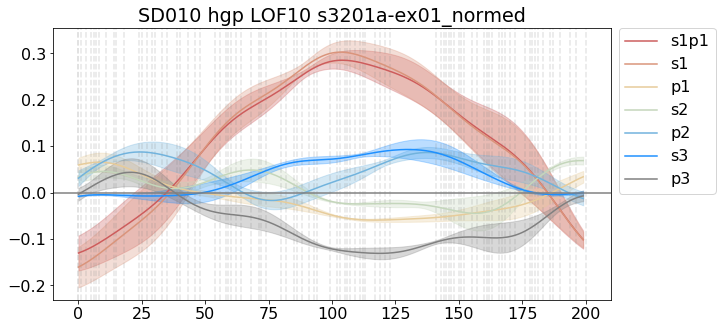

['eh', 'n', 'ch', 'k', 'l', 'ah', 's', 'g', 'oy', 'ng', 'g', 'aa', 'dh', 'ah', 'w', 'uh', 'z', 's', 'ow', 'm', 'ih', 'z', 'r', 'VOCNOISE', 'SIL', 'ah', 'uh', 'l', 'ay', 'k', 'SIL', 'dh', 'ih', 's', 't', 'uw', 'ih', 'd', 'SIL', 'dh', 'ih', 'z', 'n', 'ow', 'w', 'ey', 'dx_t', 'uw', 'l', 'ih', 'v', 'm', 'ay', 'l', 'ay', 'f', 'VOCNOISE', 's', 'ow', 'ay', 'w', 'eh', 't', 'uw', 'm', 'ay', 'k', 'aw', 's', 'l', 'er', 'ah', 's', 'ih', 'd', 'SIL', 'n', 'ow', 'f', 'r', 'eh', 'n', 'ch', 'k', 'l', 'ae', 's', 'SIL']


In [15]:
sub, ses, neu = 'SD010', '01', 'hgp'
ex = 's3201a-ex01_normed'
e_corrdic = all_mods_dic(sub, neu, ex)

colors2 = ['indianred','palegoldenrod','dodgerblue']
anchors = [0.0,0.5, 1.0]
cmap3 = LinearSegmentedColormap.from_list("mycmap2", list(zip(anchors, colors2)))
colors = [cmap3(0.0), cmap3(0.2), cmap3(0.4),cmap3(0.6), cmap3(0.8), cmap3(1.0),'grey']

mods = ['s1p1','s1','p1','s2','p2','s3','p3']
ch = "LOF10"

#for which indices to plot
idx1, idx2 = 750,950


fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.axvline(0, c='grey', ls='dashed', alpha=0.3)
for x in res:
    ax.axvline(x[1], c='grey', ls='dashed', alpha=0.2)
ch_idx = [x for x in range(len(e_corrdic['ch'])) if e_corrdic['ch'][x]==ch]
for k,col in zip(mods, colors):
    preline = e_corrdic['mods'][k][ch_idx]
    if len(preline)>800:
        line = gaussian_filter(preline, sigma=12)[:-100]
        se = window_std(line, 35)[:-20]
        if 'catalan' in ex:
            line = gaussian_filter(preline, sigma=12)[:-20]
            se = window_std(line, 12)[idx1:idx2]
        ax.plot(line[idx1:idx2], c=col, label=k)
        ax.fill_between(range(len(line[idx1:idx2])), line[idx1:idx2]-se[idx1:idx2], line[idx1:idx2]+se[idx1:idx2], color=col, alpha=0.3)
ax.axhline(0, c='grey')
ax.set_title("%s %s %s %s"%(sub, neu, ch, ex))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
plt.show()
print([x[0] for x in res])

french class going god that was so miserable and like this is stupid this is no way to live my life so I went to my councelor and said no french class

#### Figure 5e

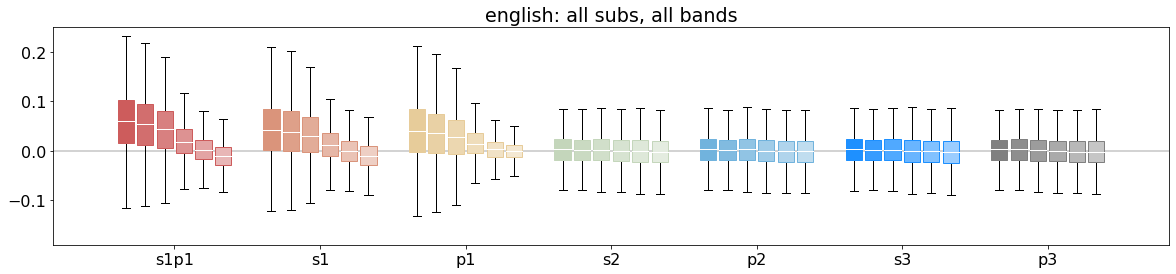

In [16]:
colors2 = ['indianred','palegoldenrod','dodgerblue']
anchors = [0.0,0.5, 1.0]
cmap3 = LinearSegmentedColormap.from_list("mycmap2", list(zip(anchors, colors2)))
colors3 = [cmap3(0.0), cmap3(0.2), cmap3(0.4),cmap3(0.6), cmap3(0.8), cmap3(1.0),(0.5, 0.5, 0.5,1.0)]

width = 0.8
all_real_values=[]
all_real_means = []
fig, ax = plt.subplots(1,1, figsize=(20,4))
for i,neu in enumerate(bands2):
    band_means = []
    band_sems = []
    for j, mod in enumerate(mods):
        intermeans=[]
        for sub, ses in sub_ses:
            intermeans.append((english_means[neu][sub][mod]))
        intermeans = np.array([x[i] for x in intermeans for i in range(len(x))])
        intermeans = intermeans[~np.isnan(intermeans)]
        bg = ax.boxplot(positions=[j-(2.5-i)*width/6], x=intermeans,widths=width/7.2, showfliers=False, showmeans=False, patch_artist=True,zorder=1)
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(bg[item], color='white')
        parts = ax.boxplot(positions=[j-(2.5-i)*width/6], x=intermeans,widths=width/7.2, showfliers=False, patch_artist=True,zorder=2)
        ax.axhline(y=0, color='lightgrey', alpha=0.1,zorder=-1)
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(parts[item], color='black')
            if item == 'boxes': plt.setp(parts[item], color=colors3[j])
            if item == 'medians': plt.setp(parts[item], color='white')
        plt.setp(parts["boxes"], facecolor=colors3[j][:3]+((9-i)/9,))
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(mods)
ax.set_title("english: all subs, all bands")
ax.set_ylim([-.19,0.25])
plt.show()

#### Figure 8a

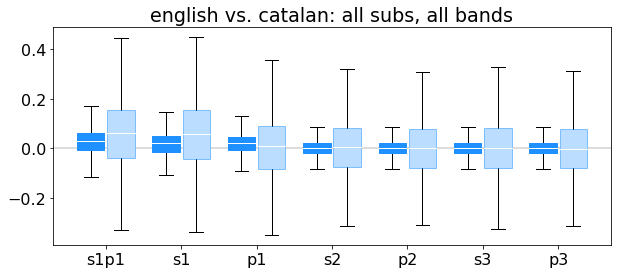

In [17]:
colors = [cmap3(0.0), cmap3(0.2), cmap3(0.4),cmap3(0.6), cmap3(0.8), cmap3(1.0),'grey']

c_means = []
cband_sems = []
for mod in mods:
    intermeans = []
    for neu in bands2:
        for sub, ses in sub_ses:
            intermeans.append((catalan_means[neu][sub][mod]))
    intermeans = np.array([x[i] for x in intermeans for i in range(len(x))])
    intermeans = intermeans[~np.isnan(intermeans)]
    cband_sems.append(stats.sem(intermeans))
    c_means.append((intermeans))
    
e_means = []
eband_sems = []
for mod in mods:
    intermeans = []
    for neu in bands2:
        for sub, ses in sub_ses:
            intermeans.append((english_means[neu][sub][mod]))
    intermeans = np.array([x[i] for x in intermeans for i in range(len(x))])
    intermeans = intermeans[~np.isnan(intermeans)]
    eband_sems.append(stats.sem(intermeans))
    e_means.append((intermeans))

width=0.8
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(mods)
for j, mod in enumerate(mods):
    bg = ax.boxplot(positions=[j-width/4], x=e_means[j],widths=width/2.2, showfliers=False, showmeans=False, patch_artist=True, zorder=100)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bg[item], color='white')
    parts = ax.boxplot(positions=[j-width/4], x=e_means[j],widths=width/2.2,showfliers=False,usermedians=[np.mean(e_means[j])],patch_artist=True,zorder=200)
    for item in ['boxes', 'whiskers', 'fliers', 'medians','caps']:
        plt.setp(parts[item], color='black', alpha=1)
        if item == 'boxes': plt.setp(parts[item], color=colors[5])
        if item == 'medians': plt.setp(parts[item], color='white')
    plt.setp(parts["boxes"], facecolor=colors[5])
for j, mod in enumerate(mods):
    bg = ax.boxplot(positions=[j+width/4], x=c_means[j],widths=width/2.2, showfliers=False, showmeans=False, patch_artist=True, zorder=100)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bg[item], color='white')
    parts = ax.boxplot(positions=[j+width/4], x=c_means[j],widths=width/2.2,showfliers=False,usermedians=[np.mean(c_means[j])],patch_artist=True,zorder=200)
    for item in ['boxes', 'whiskers', 'fliers', 'medians','caps']:
        plt.setp(parts[item], color='black')
        if item == 'boxes': plt.setp(parts[item], color=colors[5][:3]+(0.5,))
        if item == 'medians': plt.setp(parts[item], color="white")
    plt.setp(parts["boxes"], facecolor=colors[5][:3]+(0.3,))
ax.axhline(y=0, color='lightgrey',zorder=-1)
ax.set_title("english vs. catalan: all subs, all bands")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(mods)
plt.show()